# Train and export the model

In [1]:
# imports
import subprocess
from pathlib import Path
from typing import Optional, Tuple, List
from datetime import datetime

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

# Configuration
SAMPLE_RATE = 22050  # Hz
EMBEDDING_DIM = 32   # Output embedding size
HIDDEN_DIM = 256     # GRU hidden dimension
NUM_LAYERS = 2       # Number of GRU layers
BATCH_SIZE = 12      # Small batch size to fit in GPU memory
FT_BATCH_SIZE = 4
LEARNING_RATE = 1e-3
FT_LEARNING_RATE = 1e-5 # Learning rate during fine-tuning
NUM_EPOCHS = 50
FT_NUM_EPOCHS = 20
MAX_AUDIO_DURATION = 15.0  # Max duration in seconds
FT_MAX_AUDIO_DURATION = 29.0  # Max duration in seconds
FRAME_SIZE = 2048    # Frame size for CNN frontend
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
DATA_DIR = Path("../data")
FMA_SMALL_DIR = DATA_DIR / "fma_small"
HUMAN_TRIPLETS_PATH = DATA_DIR / "human_triplets.csv"
SYNTHETIC_TRIPLETS_PATH = DATA_DIR / "synthetic_triplets_just_genres.csv"
MODEL_SAVE_PATH = Path("../models")
MODEL_SAVE_PATH.mkdir(exist_ok=True)
TENSORBOARD_LOG_DIR = Path("../models/runs")
TENSORBOARD_LOG_DIR.mkdir(exist_ok=True)
AUDIO_CACHE_PICKLE_PATH = DATA_DIR / "audio_cache.pkl"

print(f"Using device: {DEVICE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Max audio duration: {MAX_AUDIO_DURATION}s")
print(f"Frame size: {FRAME_SIZE}")
print(f"TensorBoard logs: {TENSORBOARD_LOG_DIR.absolute()}")

Using device: cuda
Batch size: 12
Max audio duration: 15.0s
Frame size: 2048
TensorBoard logs: /home/anthony/Sync/mecomp-nextgen-analysis/Notebooks/../models/runs


## Load and process data

Load the human and synthetic triplets

In [2]:
# Load triplet data
human_triplets = pd.read_csv(HUMAN_TRIPLETS_PATH)
synthetic_triplets = pd.read_csv(SYNTHETIC_TRIPLETS_PATH, skiprows=1)  # Skip the header row with column types

# Filter human triplets to only keep rows where anchor and positive are set
human_triplets = human_triplets.dropna(subset=['anchor', 'positive'])
print(f"Human triplets after filtering: {len(human_triplets)}")

# Set field types
COLUMNS = [
    "anchor",
    "positive"
]
for column in COLUMNS:
    human_triplets[column] = human_triplets[column].astype(int)

# The synthetic triplets have duplicate column names, let's clean them up
# Keep only the first 3 columns (anchor, positive, negative track_ids)
synthetic_triplets = synthetic_triplets.iloc[:, :3]
synthetic_triplets.columns = ['anchor', 'positive', 'negative']
# synthetic_triplets = synthetic_triplets.sample(1000) # if we can't overfit on a subset, we aren't expressive enough

# Human triplets format: song1, song2, song3, anchor, positive
# We need to convert to anchor, positive, negative format
def convert_human_triplet(row):
    """Convert human triplet format to anchor/positive/negative format."""
    songs = [row['song1'], row['song2'], row['song3']]
    anchor_idx = row['anchor'] - 1  # Convert 1-indexed to 0-indexed
    positive_idx = row['positive'] - 1
    negative_idx = 3 - anchor_idx - positive_idx  # The remaining index
    return pd.Series({
        'anchor': songs[anchor_idx],
        'positive': songs[positive_idx],
        'negative': songs[negative_idx]
    }, dtype=int)

human_triplets_converted = human_triplets.apply(convert_human_triplet, axis=1)

print(f"Human triplets: {len(human_triplets_converted)}")
print(f"Synthetic triplets: {len(synthetic_triplets)}")
print(f"\nHuman triplets sample:")
print(human_triplets_converted.head())
print(f"\nSynthetic triplets sample:")
print(synthetic_triplets.head())

Human triplets after filtering: 50
Human triplets: 50
Synthetic triplets: 8000

Human triplets sample:
   anchor  positive  negative
0  107389     25033    142433
1  141164    123976    116883
2   73675      5940     53586
3  108808     12189     38450
4  150078     25797    123834

Synthetic triplets sample:
   anchor  positive  negative
0  145742     91306    108867
1  123979     89846     90590
2  123969     75930    152570
3  123442    137900     71276
4  141562     13767     59727


### split synthetic triples into train test and validation sets

In [3]:
# Split the human and synthetic triplets into train/validation/test sets
# For human (finetuning):
# - 70% train
# - 20% test
# - 10% validation
# for synthetic (training):
# - 50% train
# - 25% test
# - 25% validation


train_triplets, synthetic_temp = train_test_split(
    synthetic_triplets, test_size=0.3, random_state=42
)
test_triplets, val_triplets = train_test_split(
    synthetic_temp, test_size=0.33, random_state=42
)

ft_train_triplets, human_temp = train_test_split(
    human_triplets_converted, test_size=0.5, random_state=42
)
ft_test_triplets, ft_val_triplets = train_test_split(
    human_temp, test_size=0.5, random_state=42
)

# Combine synthetic triplets with human data for ... dataset
# test_triplets = pd.concat([human_test, synthetic_test], ignore_index=True)

# (human: {len(human_test)}, synthetic: {len(synthetic_test)})
print("First Round Training:")
print(f"Training triplets: {len(train_triplets)} (synthetic only)")
print(f"Validation triplets: {len(val_triplets)} (synthetic only)")
print(
    f"Test triplets: {len(test_triplets)} (synthetic only)"
)
print("Finetuning:")

print(f"Training triplets: {len(ft_train_triplets)} (human only)")
print(f"Validation triplets: {len(ft_val_triplets)} (human only)")
print(f"Test triplets: {len(ft_test_triplets)} (human only)")

First Round Training:
Training triplets: 5600 (synthetic only)
Validation triplets: 792 (synthetic only)
Test triplets: 1608 (synthetic only)
Finetuning:
Training triplets: 25 (human only)
Validation triplets: 13 (human only)
Test triplets: 12 (human only)


### create a dataloader with the raw audio for the songs for each triplet

In [4]:
from pathlib import Path

def get_audio_path(track_id: int) -> Path:
    """Get the path to an audio file given its track ID."""
    # Track IDs are stored in folders based on first 3 digits
    # e.g., track 123456 would be in fma_small/123/123456.mp3
    tid_str = f"{track_id:06d}"
    folder = tid_str[:3]
    return FMA_SMALL_DIR / folder / f"{tid_str}.mp3"


def load_audio_ffmpeg(path: Path, sample_rate: int = SAMPLE_RATE) -> Optional[np.ndarray]:
    """
    Load audio file using ffmpeg and resample to target sample rate.
    Returns mono audio as numpy array of float32 samples normalized to [-1, 1].
    """
    if not path.exists():
        return None
    
    cmd = [
        'ffmpeg',
        '-i', str(path),
        '-f', 'f32le',        # 32-bit float little-endian PCM
        '-acodec', 'pcm_f32le',
        '-ac', '1',           # Mono
        '-ar', str(sample_rate),  # Resample
        '-v', 'quiet',        # Suppress output
        '-'                   # Output to stdout
    ]
    
    try:
        result = subprocess.run(cmd, capture_output=True, check=True)
        # Use .copy() to make the array writable (frombuffer returns read-only view)
        audio = np.frombuffer(result.stdout, dtype=np.float32).copy()
        return audio
    except subprocess.CalledProcessError:
        return None

AUDIO_CACHE: dict[int, torch.Tensor] = {}
if AUDIO_CACHE_PICKLE_PATH.exists():
    AUDIO_CACHE = torch.load(AUDIO_CACHE_PICKLE_PATH)

class TripletAudioDataset(Dataset):
    """Dataset that loads triplets of audio files."""

    def __init__(
        self, 
        triplets_df: pd.DataFrame, 
        fma_dir: Path,
        sample_rate: int | None = None,
        max_duration: float = 30.0,  # Max duration in seconds
        cache_audio: bool = False
    ):
        global AUDIO_CACHE
        self.triplets: pd.DataFrame = triplets_df.reset_index(drop=True)
        self.fma_dir: Path = fma_dir
        self.sample_rate: int = sample_rate or SAMPLE_RATE
        self.max_duration: float = max_duration
        self.max_samples = int(max_duration * self.sample_rate)
        self.cache_audio: bool = cache_audio

        # Filter out triplets where any audio file is missing
        valid_indices = []
        updated_audio_cache = False
        for idx in tqdm(range(len(self.triplets)), desc="Validating audio files"):
            row = self.triplets.iloc[idx]
            anchor_path = get_audio_path(int(row['anchor']))
            positive_path = get_audio_path(int(row['positive']))
            negative_path = get_audio_path(int(row['negative']))

            if anchor_path.exists() and positive_path.exists() and negative_path.exists():
                valid_indices.append(idx)

                if self.cache_audio:
                    if int(row['anchor']) not in AUDIO_CACHE:
                        AUDIO_CACHE[int(row['anchor'])] = self._load_audio(int(row['anchor']))
                        updated_audio_cache = True
                    if int(row['positive']) not in AUDIO_CACHE:
                        AUDIO_CACHE[int(row['positive'])] = self._load_audio(int(row['positive']))
                        updated_audio_cache = True
                    if int(row['negative']) not in AUDIO_CACHE:
                        AUDIO_CACHE[int(row['negative'])] = self._load_audio(int(row['negative']))
                        updated_audio_cache = True
                    if idx % 1000 == 0 and updated_audio_cache:
                        torch.save(AUDIO_CACHE, AUDIO_CACHE_PICKLE_PATH)

        if self.cache_audio and updated_audio_cache:
            torch.save(AUDIO_CACHE, AUDIO_CACHE_PICKLE_PATH)

        self.triplets = self.triplets.iloc[valid_indices].reset_index(drop=True)
        print(f"Valid triplets: {len(self.triplets)} (removed {len(triplets_df) - len(self.triplets)} invalid)")

    def _load_audio(self, track_id: int) -> torch.Tensor:
        """Load and preprocess audio for a track."""
        global AUDIO_CACHE
        if self.cache_audio and track_id in AUDIO_CACHE:
            audio_tensor = AUDIO_CACHE[track_id]
            # Pad or truncate to max_samples
            if len(audio_tensor) < self.max_samples:
                audio_tensor = torch.nn.functional.pad(
                    audio_tensor, (0, self.max_samples - len(audio_tensor))
                )
            else:
                audio_tensor = audio_tensor[: self.max_samples]
            return audio_tensor

        path = get_audio_path(track_id)
        audio = load_audio_ffmpeg(path, self.sample_rate)

        if audio is None:
            # Return silence if loading fails
            audio = np.zeros(self.max_samples, dtype=np.float32)

        audio_tensor = torch.from_numpy(audio).float()
        if self.cache_audio:
            AUDIO_CACHE[track_id] = audio_tensor

        # Pad or truncate to max_samples
        if len(audio_tensor) < self.max_samples:
            audio_tensor = torch.nn.functional.pad(audio_tensor, (0, self.max_samples - len(audio_tensor)))
        else:
            audio_tensor = audio_tensor[: self.max_samples]

        return audio_tensor

    def __len__(self) -> int:
        return len(self.triplets)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        row = self.triplets.iloc[idx]

        anchor = self._load_audio(int(row['anchor']))
        positive = self._load_audio(int(row['positive']))
        negative = self._load_audio(int(row['negative']))

        return anchor, positive, negative


def collate_triplets(batch: List[Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]):
    """Collate function for triplet batches."""
    anchors = torch.stack([item[0] for item in batch])
    positives = torch.stack([item[1] for item in batch])
    negatives = torch.stack([item[2] for item in batch])
    return anchors, positives, negatives

In [5]:
# Create datasets with reduced duration
print("Creating training dataset...")
train_dataset = TripletAudioDataset(
    train_triplets,
    FMA_SMALL_DIR,
    max_duration=MAX_AUDIO_DURATION,
    cache_audio=True,
)

print("\nCreating validation dataset...")
val_dataset = TripletAudioDataset(
    val_triplets,
    FMA_SMALL_DIR,
    max_duration=MAX_AUDIO_DURATION,
    cache_audio=True,
)

print("\nCreating test dataset...")
test_dataset = TripletAudioDataset(
    test_triplets,
    FMA_SMALL_DIR,
    max_duration=MAX_AUDIO_DURATION,
    cache_audio=True,
)

# Create dataloaders (num_workers=0 to avoid multiprocessing issues in notebooks)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_triplets,
    num_workers=0,
    
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_triplets,
    num_workers=0,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_triplets,
    num_workers=0,
    pin_memory=True,
)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Creating training dataset...


Validating audio files:   0%|          | 0/5600 [00:00<?, ?it/s]

Valid triplets: 5600 (removed 0 invalid)

Creating validation dataset...


Validating audio files:   0%|          | 0/792 [00:00<?, ?it/s]

Valid triplets: 792 (removed 0 invalid)

Creating test dataset...


Validating audio files:   0%|          | 0/1608 [00:00<?, ?it/s]

Valid triplets: 1608 (removed 0 invalid)

Train batches: 467
Val batches: 66
Test batches: 134


## Define the model architecture

In [65]:
from torchinfo import summary
from torchview import draw_graph

def visualize_model(model: nn.Module):
    print(summary(
        model,
        input_size=(1, int(SAMPLE_RATE * MAX_AUDIO_DURATION)),
        col_names=("input_size", "output_size"),
        depth=4,
    ))
    return draw_graph(
        model,
        input_size=(1, int(SAMPLE_RATE * MAX_AUDIO_DURATION)),
        device="meta",
        strict=False,
        expand_nested=True,
        roll=True,
        depth=2,
    ).visual_graph

Layer (type:depth-idx)                   Input Shape               Output Shape
AudioEmbeddingGRU                        [1, 330750]               [1, 32]
├─Sequential: 1-1                        [161, 1, 2048]            [161, 128, 1]
│    └─Conv1d: 2-1                       [161, 1, 2048]            [161, 64, 1024]
│    └─BatchNorm1d: 2-2                  [161, 64, 1024]           [161, 64, 1024]
│    └─ReLU: 2-3                         [161, 64, 1024]           [161, 64, 1024]
│    └─MaxPool1d: 2-4                    [161, 64, 1024]           [161, 64, 512]
│    └─Conv1d: 2-5                       [161, 64, 512]            [161, 128, 256]
│    └─BatchNorm1d: 2-6                  [161, 128, 256]           [161, 128, 256]
│    └─ReLU: 2-7                         [161, 128, 256]           [161, 128, 256]
│    └─AdaptiveAvgPool1d: 2-8            [161, 128, 256]           [161, 128, 1]
├─GRU: 1-2                               [1, 161, 128]             [1, 161, 256]
├─Sequential: 1-3     

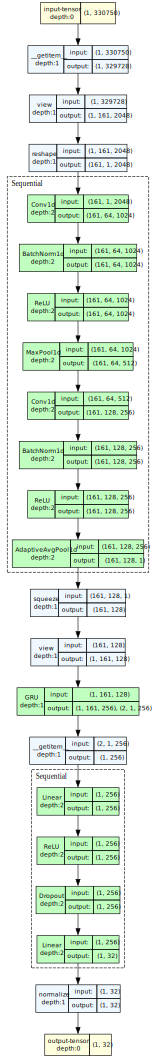

In [66]:
class AudioEmbeddingGRU(nn.Module):
    """
    GRU-based model for generating audio embeddings from raw audio frames.
    
    The model processes raw audio samples through:
    1. A 1D CNN frontend to extract local features from the raw waveform
    2. A GRU to capture temporal dependencies across the audio
    3. A projection layer to produce the final embedding
    
    Args:
        embedding_dim: Dimension of the output embedding (default: 128)
        hidden_dim: Dimension of GRU hidden state (default: 256)
        num_layers: Number of GRU layers (default: 2)
        sample_rate: Expected sample rate of input audio (default: 22050)
        frame_size: Size of each frame for the CNN frontend (default: 1024)
    """
    
    def __init__(
        self,
        embedding_dim: int = 128,
        hidden_dim: int = 256,
        num_layers: int = 2,
        sample_rate: int = 22050,
        frame_size: int = 1024,
        dropout: float = 0.2
    ):
        super().__init__()
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.sample_rate = sample_rate
        self.frame_size = frame_size
        
        # CNN frontend to extract features from raw audio frames
        # Input: (batch, 1, frame_size) -> Output: (batch, cnn_out_dim)
        self.cnn_frontend = nn.Sequential(
            # First conv block
            nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            # Second conv block
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            # nn.MaxPool1d(kernel_size=2, stride=2),
            
            # # Third conv block
            # nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm1d(256),
            # nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool1d(1),  # Global average pooling
        )
        
        # Calculate CNN output dimension
        self.cnn_out_dim = 128
        
        # GRU for temporal modeling
        self.gru = nn.GRU(
            input_size=self.cnn_out_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        
        # Projection head to embedding space
        self.projection = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embedding_dim)
        )
        
        # L2 normalization for embeddings
        self.normalize = True
    
    def _extract_frames(self, audio: torch.Tensor) -> torch.Tensor:
        """
        Extract non-overlapping frames from raw audio.
        Each frame is independent - no overlap between frames.
        
        Args:
            audio: Raw audio tensor of shape (batch, num_samples)
            
        Returns:
            Frames tensor of shape (batch, num_frames, frame_size)
        """
        batch_size, num_samples = audio.shape
        
        # Calculate number of complete frames (non-overlapping)
        num_frames = num_samples // self.frame_size
        
        # Truncate to complete frames only
        usable_samples = num_frames * self.frame_size
        audio_truncated = audio[:, :usable_samples]
        
        # Reshape to (batch, num_frames, frame_size)
        frames = audio_truncated.view(batch_size, num_frames, self.frame_size)
        
        return frames
    
    def forward(self, audio: torch.Tensor) -> torch.Tensor:
        """
        Generate embedding from raw audio.
        
        Args:
            audio: Raw audio tensor of shape (batch, num_samples)
            
        Returns:
            Embedding tensor of shape (batch, embedding_dim)
        """
        batch_size = audio.shape[0]
        
        # Extract frames from audio (non-overlapping)
        frames = self._extract_frames(audio)  # (batch, num_frames, frame_size)
        num_frames = frames.shape[1]
        
        # Reshape for CNN: (batch * num_frames, 1, frame_size)
        frames_flat = frames.reshape(-1, 1, self.frame_size)
        
        # Apply CNN frontend
        cnn_out = self.cnn_frontend(frames_flat)  # (batch * num_frames, cnn_out_dim, 1)
        cnn_out = cnn_out.squeeze(-1)  # (batch * num_frames, cnn_out_dim)
        
        # Reshape back to sequence: (batch, num_frames, cnn_out_dim)
        cnn_out = cnn_out.view(batch_size, num_frames, -1)
        
        # Apply GRU
        gru_out, hidden = self.gru(cnn_out)  # gru_out: (batch, num_frames, hidden_dim)
        
        # Use final hidden state for embedding
        final_hidden = hidden[-1]  # (batch, hidden_dim)
        
        # Project to embedding space
        embedding = self.projection(final_hidden)  # (batch, embedding_dim)
        
        # L2 normalize embeddings
        if self.normalize:
            embedding = F.normalize(embedding, p=2, dim=1)
        
        return embedding
    
    def get_embedding_dim(self) -> int:
        """Return the embedding dimension."""
        return self.embedding_dim


# Create model instance with configured frame size
model = AudioEmbeddingGRU(
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    sample_rate=SAMPLE_RATE,
    frame_size=FRAME_SIZE,
    dropout=0.1
).to(DEVICE)

# # Print model summary
# print(model)
# print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
# print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
visualize_model(model)

Layer (type:depth-idx)                   Input Shape               Output Shape
AudioEmbeddingTiny                       [1, 330750]               [1, 32]
├─Sequential: 1-1                        [161, 1, 2048]            [161, 64, 1]
│    └─DepthwiseBlock: 2-1               [161, 1, 2048]            [161, 32, 1024]
│    │    └─Sequential: 3-1              [161, 1, 2048]            [161, 32, 1024]
│    │    │    └─Conv1d: 4-1             [161, 1, 2048]            [161, 1, 1024]
│    │    │    └─BatchNorm1d: 4-2        [161, 1, 1024]            [161, 1, 1024]
│    │    │    └─GELU: 4-3               [161, 1, 1024]            [161, 1, 1024]
│    │    │    └─Conv1d: 4-4             [161, 1, 1024]            [161, 32, 1024]
│    │    │    └─BatchNorm1d: 4-5        [161, 32, 1024]           [161, 32, 1024]
│    │    │    └─GELU: 4-6               [161, 32, 1024]           [161, 32, 1024]
│    └─DepthwiseBlock: 2-2               [161, 32, 1024]           [161, 64, 512]
│    │    └─Sequential

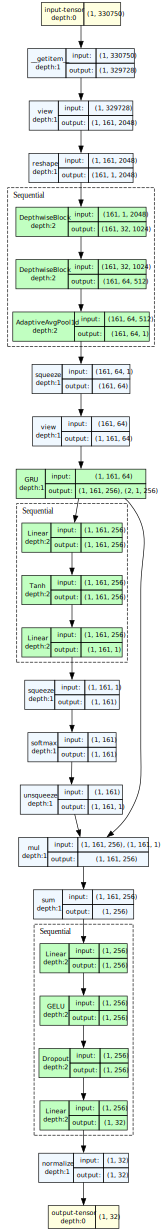

In [67]:
class DepthwiseBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k=5, s=2, p=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(
                in_ch,
                in_ch,
                kernel_size=k,
                stride=s,
                padding=p,
                groups=in_ch,
                bias=False,
            ),
            nn.BatchNorm1d(in_ch),
            nn.GELU(),
            nn.Conv1d(in_ch, out_ch, kernel_size=1, bias=False),
            nn.BatchNorm1d(out_ch),
            nn.GELU(),
        )

    def forward(self, x):
        return self.net(x)


class AudioEmbeddingTiny(nn.Module):
    """
    Raw-audio → depthwise CNN → GRU → attention pooling → projection + L2.
    """

    def __init__(
        self,
        embedding_dim: int = 32,
        cnn_channels: tuple[int, ...] = (32, 64, 96),
        hidden_dim: int = 128,
        num_layers: int = 1,
        sample_rate: int = 22050,
        frame_size: int = 1024,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.frame_size = frame_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.sample_rate = sample_rate

        blocks = []
        in_ch = 1
        for ch in cnn_channels:
            blocks.append(DepthwiseBlock(in_ch, ch, k=5, s=2, p=2))
            in_ch = ch
        blocks.append(nn.AdaptiveAvgPool1d(1))  # pool per frame
        self.cnn_frontend = nn.Sequential(*blocks)
        self.cnn_out_dim = in_ch

        self.gru = nn.GRU(
            input_size=self.cnn_out_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )

        # Attention pooling over time
        self.attn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(), nn.Linear(hidden_dim, 1)
        )

        self.projection = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embedding_dim),
        )

    def _extract_frames(self, audio: torch.Tensor) -> torch.Tensor:
        # audio: (B, T); returns (B, num_frames, frame_size)
        b, t = audio.shape
        num_frames = t // self.frame_size
        usable = num_frames * self.frame_size
        audio = audio[:, :usable]
        frames = audio.view(b, num_frames, self.frame_size)
        return frames

    def forward(self, audio: torch.Tensor) -> torch.Tensor:
        b = audio.shape[0]
        frames = self._extract_frames(audio)  # (B, F, L)
        frames_flat = frames.reshape(-1, 1, self.frame_size)  # (B*F, 1, L)
        cnn_out = self.cnn_frontend(frames_flat).squeeze(-1)  # (B*F, C)
        seq = cnn_out.view(b, -1, self.cnn_out_dim)  # (B, F, C)

        gru_out, _ = self.gru(seq)  # (B, F, H)

        # Attention pooling
        attn_scores = self.attn(gru_out).squeeze(-1)  # (B, F)
        attn_weights = torch.softmax(attn_scores, dim=1).unsqueeze(-1)
        pooled = (gru_out * attn_weights).sum(dim=1)  # (B, H)

        emb = self.projection(pooled)  # (B, D)
        emb = F.normalize(emb, p=2, dim=1)
        return emb

    def get_embedding_dim(self) -> int:
        return self.embedding_dim


# Example instantiation mirroring your current config
model = AudioEmbeddingTiny(
    embedding_dim=EMBEDDING_DIM,
    cnn_channels=(32, 64),
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    frame_size=FRAME_SIZE,  # match your FRAME_SIZE
    dropout=0.1,
).to(DEVICE)


# Print model summary
visualize_model(model)
# print(model)
# print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
# print(
#     f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}"
# )

In [8]:
# Calculate memory usage estimate
num_samples = int(SAMPLE_RATE * MAX_AUDIO_DURATION)
num_frames = num_samples // FRAME_SIZE
print(f"\nWith {MAX_AUDIO_DURATION}s audio @ {SAMPLE_RATE}Hz:")
print(f"  Samples per audio: {num_samples:,}")
print(f"  Frames per audio: {num_frames}")
print(f"  Frames per batch (x3 for triplet): {BATCH_SIZE * 3 * num_frames:,}")

# Quick test with dummy input
dummy_input = torch.randn(2, int(SAMPLE_RATE * MAX_AUDIO_DURATION)).to(DEVICE)
dummy_output = model(dummy_input)
print(f"\nTest input shape: {dummy_input.shape}")
print(f"Test output shape: {dummy_output.shape}")


With 15.0s audio @ 22050Hz:
  Samples per audio: 330,750
  Frames per audio: 161
  Frames per batch (x3 for triplet): 5,796

Test input shape: torch.Size([2, 330750])
Test output shape: torch.Size([2, 32])


## Train and Test loops

In [9]:
class TripletMarginLossWithAccuracy(nn.Module):
    """
    Triplet margin loss with accuracy tracking.
    
    For triplet (anchor, positive, negative), the loss is:
    max(0, margin + d(anchor, positive) - d(anchor, negative))
    
    Accuracy is measured as the percentage of triplets where:
    d(anchor, positive) < d(anchor, negative)
    """
    
    def __init__(self, margin: float = 0.2):
        super().__init__()
        self.margin = margin
    
    def forward(
        self, 
        anchor: torch.Tensor, 
        positive: torch.Tensor, 
        negative: torch.Tensor
    ) -> Tuple[torch.Tensor, float, float, float]:
        """
        Compute triplet loss and accuracy.
        
        Args:
            anchor: Anchor embeddings (batch, embedding_dim)
            positive: Positive embeddings (batch, embedding_dim)
            negative: Negative embeddings (batch, embedding_dim)
            
        Returns:
            loss: Scalar loss tensor
            accuracy: Float accuracy (0-1)
            avg_dist_pos: Average distance to positive
            avg_dist_neg: Average distance to negative
        """
        # Compute L2 distances
        dist_pos = F.pairwise_distance(anchor, positive, p=2)
        dist_neg = F.pairwise_distance(anchor, negative, p=2)
        
        # Triplet margin loss
        losses = F.relu(self.margin + dist_pos - dist_neg)
        loss = losses.mean()
        
        # Accuracy: positive should be closer than negative
        correct = (dist_pos < dist_neg).float()
        accuracy = correct.mean().item()
        
        # Average distances for logging
        avg_dist_pos = dist_pos.mean().item()
        avg_dist_neg = dist_neg.mean().item()
        
        return loss, accuracy, avg_dist_pos, avg_dist_neg


def train_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    epoch: int,
    writer: Optional[SummaryWriter] = None,
    global_step: int = 0
) -> Tuple[float, float, float, float, int]:
    """Train for one epoch with TensorBoard logging."""
    model.train()
    total_loss = 0.0
    total_accuracy = 0.0
    total_dist_pos = 0.0
    total_dist_neg = 0.0
    num_batches = 0
    
    pbar = tqdm(dataloader, desc=f"Epoch {epoch} [Train]")
    for anchors, positives, negatives in pbar:
        anchors = anchors.to(device)
        positives = positives.to(device)
        negatives = negatives.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        anchor_emb = model(anchors)
        positive_emb = model(positives)
        negative_emb = model(negatives)
        
        # Compute loss
        loss, accuracy, dist_pos, dist_neg = criterion(anchor_emb, positive_emb, negative_emb)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        
        total_loss += loss.item()
        total_accuracy += accuracy
        total_dist_pos += dist_pos
        total_dist_neg += dist_neg
        num_batches += 1
        global_step += 1
        
        # Log batch metrics to TensorBoard
        if writer is not None:
            writer.add_scalar('Train/BatchLoss', loss.item(), global_step)
            writer.add_scalar('Train/BatchAccuracy', accuracy, global_step)
            writer.add_scalar('Train/GradNorm', grad_norm.item(), global_step)
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{accuracy:.4f}'
        })
    
    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches
    avg_dist_pos = total_dist_pos / num_batches
    avg_dist_neg = total_dist_neg / num_batches
    
    return avg_loss, avg_accuracy, avg_dist_pos, avg_dist_neg, global_step


@torch.no_grad()
def evaluate(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
    desc: str = "Eval"
) -> Tuple[float, float, float, float]:
    """Evaluate the model."""
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    total_dist_pos = 0.0
    total_dist_neg = 0.0
    num_batches = 0
    
    for anchors, positives, negatives in tqdm(dataloader, desc=desc):
        anchors = anchors.to(device)
        positives = positives.to(device)
        negatives = negatives.to(device)
        
        # Forward pass
        anchor_emb = model(anchors)
        positive_emb = model(positives)
        negative_emb = model(negatives)
        
        # Compute loss
        loss, accuracy, dist_pos, dist_neg = criterion(anchor_emb, positive_emb, negative_emb)
        
        total_loss += loss.item()
        total_accuracy += accuracy
        total_dist_pos += dist_pos
        total_dist_neg += dist_neg
        num_batches += 1
    
    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches
    avg_dist_pos = total_dist_pos / num_batches
    avg_dist_neg = total_dist_neg / num_batches
    
    return avg_loss, avg_accuracy, avg_dist_pos, avg_dist_neg

In [10]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: Optional[torch.optim.lr_scheduler._LRScheduler],
    device: torch.device,
    num_epochs: int,
    save_path: Path,
    writer: Optional[SummaryWriter] = None,
    early_stopping_patience: int = 10,
    checkpoint_name:str|None = None,
    scheduler_based_on_epoch: bool = False
) -> dict:
    """
    Full training loop with validation, early stopping, and TensorBoard logging.
    
    Returns:
        Dictionary with training history
    """
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': [],
        'lr': []
    }

    best_val_accuracy = -0.01
    patience_counter = 0
    global_step = 0

    # Log model graph to TensorBoard
    if writer is not None:
        try:
            dummy_input = torch.randn(1, int(SAMPLE_RATE * MAX_AUDIO_DURATION)).to(device)
            writer.add_graph(model, dummy_input)
        except Exception as e:
            print(f"Could not log model graph: {e}")

    for epoch in range(1, num_epochs + 1):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch}/{num_epochs}")
        print(f"{'='*60}")

        # Train
        train_loss, train_acc, train_dist_pos, train_dist_neg, global_step = train_epoch(
            model, train_loader, criterion, optimizer, device, epoch,
            writer=writer, global_step=global_step
        )

        # Validate
        val_loss, val_acc, val_dist_pos, val_dist_neg = evaluate(
            model, val_loader, criterion, device, desc="Validation"
        )

        # Update learning rate
        current_lr = optimizer.param_groups[0]['lr']
        if scheduler is not None:
            scheduler.step(epoch if scheduler_based_on_epoch else val_loss) # type: ignore

        # Record history
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)
        history['lr'].append(current_lr)

        # Log epoch metrics to TensorBoard
        if writer is not None:
            # Loss
            writer.add_scalar(
                "Train/Loss",
                train_loss,
                epoch,
            )
            writer.add_scalar(
                "Validation/Loss",
                val_loss,
                epoch,
            )

            # Accuracy
            writer.add_scalar("Train/Accuracy", train_acc, epoch)
            writer.add_scalar("Validation/Accuracy", val_acc, epoch)

            # Distances
            writer.add_scalar(
                "Train/Distance/Positive",
                train_dist_pos,
                epoch,
            )
            writer.add_scalar(
                "Validation/Distance/Positive",
                val_dist_pos,
                epoch,
            )
            writer.add_scalar(
                "Train/Distance/Negative",
                train_dist_neg,
                epoch,
            )
            writer.add_scalar(
                "Validation/Distance/Negative",
                val_dist_neg,
                epoch,
            )

            # Distance margin (negative - positive, should be > 0)
            writer.add_scalar(
                "Train/Distance/Margin", train_dist_neg - train_dist_pos, epoch
            )
            writer.add_scalar(
                "Validation/Distance/Margin",
                val_dist_neg - val_dist_pos,
                epoch,
            )

            # Learning rate
            writer.add_scalar('LearningRate', current_lr, epoch)

        print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        print(f"Learning Rate: {current_lr:.6f}")

        # Save best model
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            patience_counter = 0
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "val_accuracy": val_acc,
                    "val_loss": val_loss,
                    "config": {
                        "embedding_dim": model.embedding_dim,
                        "hidden_dim": model.hidden_dim,
                        "num_layers": model.num_layers,
                        "sample_rate": model.sample_rate,
                        "frame_size": model.frame_size,
                    },
                },
                save_path / (checkpoint_name or "best_model.pt"),
            )
            print(f"✓ New best model saved! (Val Acc: {val_acc:.4f})")
        else:
            patience_counter += 1
            print(f"No improvement. Patience: {patience_counter}/{early_stopping_patience}")

        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f"\nEarly stopping triggered after {epoch} epochs")
            break

    # Load best model
    checkpoint = torch.load(save_path / (checkpoint_name or 'best_model.pt'))
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"\nLoaded best model from epoch {checkpoint['epoch']} with Val Acc: {checkpoint['val_accuracy']:.4f}")

    return history

## Train the model on synthetic data

In [11]:
# Setup training
criterion = TripletMarginLossWithAccuracy(margin=0.2)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

# Create TensorBoard writer with timestamp
run_name = f"audio_embedding_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
writer = SummaryWriter(log_dir=TENSORBOARD_LOG_DIR / run_name)

# Log hyperparameters
hparams = {
    'embedding_dim': EMBEDDING_DIM,
    'hidden_dim': HIDDEN_DIM,
    'num_layers': NUM_LAYERS,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'frame_size': FRAME_SIZE,
    'max_audio_duration': MAX_AUDIO_DURATION,
    'sample_rate': SAMPLE_RATE,
}
writer.add_hparams(hparams, {})

print(f"TensorBoard run: {run_name}")
print(f"Run 'tensorboard --logdir {TENSORBOARD_LOG_DIR.absolute()}' to view logs")

# Train the model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler, # type: ignore
    device=DEVICE,
    num_epochs=NUM_EPOCHS,
    save_path=MODEL_SAVE_PATH,
    writer=writer,
    early_stopping_patience=10
)

# Evaluate on test set
print("\n" + "="*60)
print("Final Test Evaluation")
print("="*60)
test_loss, test_acc, test_dist_pos, test_dist_neg = evaluate(model, test_loader, criterion, DEVICE, desc="Test")
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# Log final test metrics
writer.add_scalar('Test/Loss', test_loss, 0)
writer.add_scalar('Test/Accuracy', test_acc, 0)
writer.add_scalar('Test/DistancePositive', test_dist_pos, 0)
writer.add_scalar('Test/DistanceNegative', test_dist_neg, 0)

# Close TensorBoard writer
writer.close()
print("\nTensorBoard writer closed.")

TensorBoard run: audio_embedding_20251210_193659
Run 'tensorboard --logdir /home/anthony/Sync/mecomp-nextgen-analysis/Notebooks/../models/runs' to view logs

Epoch 1/50


Epoch 1 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1924 | Train Acc: 0.5379
Val Loss: 0.1890 | Val Acc: 0.5720
Learning Rate: 0.001000
✓ New best model saved! (Val Acc: 0.5720)

Epoch 2/50


Epoch 2 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1865 | Train Acc: 0.5592
Val Loss: 0.1960 | Val Acc: 0.5821
Learning Rate: 0.001000
✓ New best model saved! (Val Acc: 0.5821)

Epoch 3/50


Epoch 3 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1822 | Train Acc: 0.5646
Val Loss: 0.1841 | Val Acc: 0.5745
Learning Rate: 0.001000
No improvement. Patience: 1/10

Epoch 4/50


Epoch 4 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1782 | Train Acc: 0.5918
Val Loss: 0.1856 | Val Acc: 0.5947
Learning Rate: 0.001000
✓ New best model saved! (Val Acc: 0.5947)

Epoch 5/50


Epoch 5 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1799 | Train Acc: 0.5849
Val Loss: 0.1719 | Val Acc: 0.6174
Learning Rate: 0.001000
✓ New best model saved! (Val Acc: 0.6174)

Epoch 6/50


Epoch 6 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1725 | Train Acc: 0.5988
Val Loss: 0.1744 | Val Acc: 0.6199
Learning Rate: 0.001000
✓ New best model saved! (Val Acc: 0.6199)

Epoch 7/50


Epoch 7 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1697 | Train Acc: 0.6055
Val Loss: 0.1689 | Val Acc: 0.6010
Learning Rate: 0.001000
No improvement. Patience: 1/10

Epoch 8/50


Epoch 8 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1674 | Train Acc: 0.6086
Val Loss: 0.1688 | Val Acc: 0.6326
Learning Rate: 0.001000
✓ New best model saved! (Val Acc: 0.6326)

Epoch 9/50


Epoch 9 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1665 | Train Acc: 0.6181
Val Loss: 0.1619 | Val Acc: 0.6326
Learning Rate: 0.001000
No improvement. Patience: 1/10

Epoch 10/50


Epoch 10 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1632 | Train Acc: 0.6257
Val Loss: 0.1573 | Val Acc: 0.6338
Learning Rate: 0.001000
✓ New best model saved! (Val Acc: 0.6338)

Epoch 11/50


Epoch 11 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1601 | Train Acc: 0.6373
Val Loss: 0.1544 | Val Acc: 0.6490
Learning Rate: 0.001000
✓ New best model saved! (Val Acc: 0.6490)

Epoch 12/50


Epoch 12 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1583 | Train Acc: 0.6418
Val Loss: 0.1579 | Val Acc: 0.6364
Learning Rate: 0.001000
No improvement. Patience: 1/10

Epoch 13/50


Epoch 13 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1568 | Train Acc: 0.6396
Val Loss: 0.1561 | Val Acc: 0.6351
Learning Rate: 0.001000
No improvement. Patience: 2/10

Epoch 14/50


Epoch 14 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1555 | Train Acc: 0.6452
Val Loss: 0.1559 | Val Acc: 0.6503
Learning Rate: 0.001000
✓ New best model saved! (Val Acc: 0.6503)

Epoch 15/50


Epoch 15 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1553 | Train Acc: 0.6564
Val Loss: 0.1483 | Val Acc: 0.6667
Learning Rate: 0.001000
✓ New best model saved! (Val Acc: 0.6667)

Epoch 16/50


Epoch 16 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1526 | Train Acc: 0.6559
Val Loss: 0.1544 | Val Acc: 0.6578
Learning Rate: 0.001000
No improvement. Patience: 1/10

Epoch 17/50


Epoch 17 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1510 | Train Acc: 0.6643
Val Loss: 0.1552 | Val Acc: 0.6540
Learning Rate: 0.001000
No improvement. Patience: 2/10

Epoch 18/50


Epoch 18 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1501 | Train Acc: 0.6593
Val Loss: 0.1485 | Val Acc: 0.6755
Learning Rate: 0.001000
✓ New best model saved! (Val Acc: 0.6755)

Epoch 19/50


Epoch 19 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1480 | Train Acc: 0.6633
Val Loss: 0.1500 | Val Acc: 0.6641
Learning Rate: 0.001000
No improvement. Patience: 1/10

Epoch 20/50


Epoch 20 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1468 | Train Acc: 0.6732
Val Loss: 0.1552 | Val Acc: 0.6427
Learning Rate: 0.001000
No improvement. Patience: 2/10

Epoch 21/50


Epoch 21 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1451 | Train Acc: 0.6754
Val Loss: 0.1434 | Val Acc: 0.6869
Learning Rate: 0.001000
✓ New best model saved! (Val Acc: 0.6869)

Epoch 22/50


Epoch 22 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1438 | Train Acc: 0.6758
Val Loss: 0.1544 | Val Acc: 0.6654
Learning Rate: 0.001000
No improvement. Patience: 1/10

Epoch 23/50


Epoch 23 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1406 | Train Acc: 0.6921
Val Loss: 0.1451 | Val Acc: 0.6806
Learning Rate: 0.001000
No improvement. Patience: 2/10

Epoch 24/50


Epoch 24 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1384 | Train Acc: 0.6971
Val Loss: 0.1451 | Val Acc: 0.6806
Learning Rate: 0.001000
No improvement. Patience: 3/10

Epoch 25/50


Epoch 25 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1368 | Train Acc: 0.7015
Val Loss: 0.1516 | Val Acc: 0.6742
Learning Rate: 0.001000
No improvement. Patience: 4/10

Epoch 26/50


Epoch 26 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1338 | Train Acc: 0.7047
Val Loss: 0.1432 | Val Acc: 0.6995
Learning Rate: 0.001000
✓ New best model saved! (Val Acc: 0.6995)

Epoch 27/50


Epoch 27 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1312 | Train Acc: 0.7140
Val Loss: 0.1498 | Val Acc: 0.6629
Learning Rate: 0.001000
No improvement. Patience: 1/10

Epoch 28/50


Epoch 28 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1280 | Train Acc: 0.7237
Val Loss: 0.1439 | Val Acc: 0.6780
Learning Rate: 0.001000
No improvement. Patience: 2/10

Epoch 29/50


Epoch 29 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1236 | Train Acc: 0.7401
Val Loss: 0.1482 | Val Acc: 0.6730
Learning Rate: 0.001000
No improvement. Patience: 3/10

Epoch 30/50


Epoch 30 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1219 | Train Acc: 0.7441
Val Loss: 0.1474 | Val Acc: 0.6742
Learning Rate: 0.001000
No improvement. Patience: 4/10

Epoch 31/50


Epoch 31 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1203 | Train Acc: 0.7387
Val Loss: 0.1533 | Val Acc: 0.6705
Learning Rate: 0.001000
No improvement. Patience: 5/10

Epoch 32/50


Epoch 32 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1157 | Train Acc: 0.7586
Val Loss: 0.1474 | Val Acc: 0.6806
Learning Rate: 0.001000
No improvement. Patience: 6/10

Epoch 33/50


Epoch 33 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.1048 | Train Acc: 0.7786
Val Loss: 0.1554 | Val Acc: 0.6679
Learning Rate: 0.000500
No improvement. Patience: 7/10

Epoch 34/50


Epoch 34 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.0977 | Train Acc: 0.7965
Val Loss: 0.1512 | Val Acc: 0.6932
Learning Rate: 0.000500
No improvement. Patience: 8/10

Epoch 35/50


Epoch 35 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.0938 | Train Acc: 0.8124
Val Loss: 0.1511 | Val Acc: 0.6919
Learning Rate: 0.000500
No improvement. Patience: 9/10

Epoch 36/50


Epoch 36 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]


Train Loss: 0.0874 | Train Acc: 0.8209
Val Loss: 0.1601 | Val Acc: 0.6679
Learning Rate: 0.000500
No improvement. Patience: 10/10

Early stopping triggered after 36 epochs

Loaded best model from epoch 26 with Val Acc: 0.6995

Final Test Evaluation


Test:   0%|          | 0/134 [00:00<?, ?it/s]

Test Loss: 0.1554 | Test Accuracy: 0.6449

TensorBoard writer closed.


## Finetune the model on human triples

In [12]:
# Load the best model from previous training
checkpoint = torch.load(MODEL_SAVE_PATH / "best_model.pt")
model.load_state_dict(checkpoint['model_state_dict'])
print(f"\nLoaded best model from epoch {checkpoint['epoch']} with Val Acc: {checkpoint['val_accuracy']:.4f}")

# Clear GPU memory before fine-tuning
import gc

# Delete the previous dataloaders and datasets to free memory
try:
    del train_loader, val_loader, test_loader
    del train_dataset, val_dataset, test_dataset
except NameError:
    ...

# Clear Python garbage collector
gc.collect()

# Clear CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1024**2:.1f} MB")
    print(f"GPU memory reserved: {torch.cuda.memory_reserved() / 1024**2:.1f} MB")

print("GPU memory cleared!")


Loaded best model from epoch 26 with Val Acc: 0.6995
GPU memory allocated: 318.6 MB
GPU memory reserved: 612.0 MB
GPU memory cleared!


### Create data loaders

In [13]:
# Create datasets with full duration
print("Creating training dataset...")
ft_train_dataset = TripletAudioDataset(
    ft_train_triplets, FMA_SMALL_DIR, max_duration=FT_MAX_AUDIO_DURATION, cache_audio=True,
)

print("\nCreating validation dataset...")
ft_val_dataset = TripletAudioDataset(
    ft_val_triplets, FMA_SMALL_DIR, max_duration=FT_MAX_AUDIO_DURATION, cache_audio=True,
)

print("\nCreating test dataset...")
ft_test_dataset = TripletAudioDataset(
    ft_test_triplets, FMA_SMALL_DIR, max_duration=FT_MAX_AUDIO_DURATION, cache_audio=True,
)


# Create dataloaders (num_workers=0 to avoid multiprocessing issues in notebooks)
ft_train_loader = DataLoader(
    ft_train_dataset,
    batch_size=FT_BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_triplets,
    num_workers=0,
    pin_memory=True,
)

ft_val_loader = DataLoader(
    ft_val_dataset,
    batch_size=FT_BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_triplets,
    num_workers=0,
    pin_memory=True,
)

ft_test_loader = DataLoader(
    ft_test_dataset,
    batch_size=FT_BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_triplets,
    num_workers=0,
    pin_memory=True,
)

print(f"\nTrain batches: {len(ft_train_loader)}")
print(f"Val batches: {len(ft_val_loader)}")
print(f"Test batches: {len(ft_test_loader)}")

Creating training dataset...


Validating audio files:   0%|          | 0/25 [00:00<?, ?it/s]

Valid triplets: 25 (removed 0 invalid)

Creating validation dataset...


Validating audio files:   0%|          | 0/13 [00:00<?, ?it/s]

Valid triplets: 13 (removed 0 invalid)

Creating test dataset...


Validating audio files:   0%|          | 0/12 [00:00<?, ?it/s]

Valid triplets: 12 (removed 0 invalid)

Train batches: 7
Val batches: 4
Test batches: 3


# Finetune model

In [14]:
# if run_time is not defined, define it for fine-tuning
try:
    run_name
except NameError:
    run_name = f"audio_embedding_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

In [15]:
# Setup training
criterion = TripletMarginLossWithAccuracy(margin=0.2)
optimizer = torch.optim.AdamW(model.parameters(), lr=FT_LEARNING_RATE, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5
)

# Create TensorBoard writer with timestamp
ft_run_name = f"finetuned_{run_name}" # append "finetuned" to the previous run
writer = SummaryWriter(log_dir=TENSORBOARD_LOG_DIR / ft_run_name)

# Log hyperparameters
hparams = {
    "embedding_dim": EMBEDDING_DIM,
    "hidden_dim": HIDDEN_DIM,
    "num_layers": NUM_LAYERS,
    "batch_size": FT_BATCH_SIZE,
    "learning_rate": FT_LEARNING_RATE,
    "frame_size": FRAME_SIZE,
    "max_audio_duration": FT_MAX_AUDIO_DURATION,
    "sample_rate": SAMPLE_RATE,
}
writer.add_hparams(hparams, {})

print(f"TensorBoard run: {ft_run_name}")
print(f"Run 'tensorboard --logdir {TENSORBOARD_LOG_DIR.absolute()}' to view logs")

# Train the model
history = train_model(
    model=model,
    train_loader=ft_train_loader,
    val_loader=ft_val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,  # type: ignore
    device=DEVICE,
    num_epochs=FT_NUM_EPOCHS,
    save_path=MODEL_SAVE_PATH,
    writer=writer,
    early_stopping_patience=10,
    checkpoint_name="best_finetuned_model.pt",
)

# Evaluate on test set
print("\n" + "=" * 60)
print("Final Test Evaluation")
print("=" * 60)
test_loss, test_acc, test_dist_pos, test_dist_neg = evaluate(
    model, ft_test_loader, criterion, DEVICE, desc="Test"
)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# Log final test metrics
writer.add_scalar("Test/Loss", test_loss, 0)
writer.add_scalar("Test/Accuracy", test_acc, 0)
writer.add_scalar("Test/DistancePositive", test_dist_pos, 0)
writer.add_scalar("Test/DistanceNegative", test_dist_neg, 0)

# Close TensorBoard writer
writer.close()
print("\nTensorBoard writer closed.")

TensorBoard run: finetuned_audio_embedding_20251210_193659
Run 'tensorboard --logdir /home/anthony/Sync/mecomp-nextgen-analysis/Notebooks/../models/runs' to view logs

Epoch 1/20


Epoch 1 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.2299 | Train Acc: 0.5714
Val Loss: 0.2391 | Val Acc: 0.2500
Learning Rate: 0.000010
✓ New best model saved! (Val Acc: 0.2500)

Epoch 2/20


Epoch 2 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.1987 | Train Acc: 0.5714
Val Loss: 0.2327 | Val Acc: 0.2500
Learning Rate: 0.000010
No improvement. Patience: 1/10

Epoch 3/20


Epoch 3 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.1727 | Train Acc: 0.6429
Val Loss: 0.2337 | Val Acc: 0.5625
Learning Rate: 0.000010
✓ New best model saved! (Val Acc: 0.5625)

Epoch 4/20


Epoch 4 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.1987 | Train Acc: 0.5000
Val Loss: 0.2346 | Val Acc: 0.5625
Learning Rate: 0.000010
No improvement. Patience: 1/10

Epoch 5/20


Epoch 5 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.1811 | Train Acc: 0.6429
Val Loss: 0.2374 | Val Acc: 0.3125
Learning Rate: 0.000010
No improvement. Patience: 2/10

Epoch 6/20


Epoch 6 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.2070 | Train Acc: 0.5357
Val Loss: 0.2384 | Val Acc: 0.2500
Learning Rate: 0.000010
No improvement. Patience: 3/10

Epoch 7/20


Epoch 7 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.1834 | Train Acc: 0.6786
Val Loss: 0.2406 | Val Acc: 0.3125
Learning Rate: 0.000010
No improvement. Patience: 4/10

Epoch 8/20


Epoch 8 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.1891 | Train Acc: 0.5357
Val Loss: 0.2344 | Val Acc: 0.2500
Learning Rate: 0.000010
No improvement. Patience: 5/10

Epoch 9/20


Epoch 9 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.1425 | Train Acc: 0.7143
Val Loss: 0.2398 | Val Acc: 0.3125
Learning Rate: 0.000005
No improvement. Patience: 6/10

Epoch 10/20


Epoch 10 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.1473 | Train Acc: 0.7143
Val Loss: 0.2415 | Val Acc: 0.6250
Learning Rate: 0.000005
✓ New best model saved! (Val Acc: 0.6250)

Epoch 11/20


Epoch 11 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.1522 | Train Acc: 0.7143
Val Loss: 0.2354 | Val Acc: 0.5000
Learning Rate: 0.000005
No improvement. Patience: 1/10

Epoch 12/20


Epoch 12 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.1370 | Train Acc: 0.7857
Val Loss: 0.2322 | Val Acc: 0.5625
Learning Rate: 0.000005
No improvement. Patience: 2/10

Epoch 13/20


Epoch 13 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.2210 | Train Acc: 0.5000
Val Loss: 0.2355 | Val Acc: 0.5625
Learning Rate: 0.000005
No improvement. Patience: 3/10

Epoch 14/20


Epoch 14 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.1496 | Train Acc: 0.6429
Val Loss: 0.2259 | Val Acc: 0.5625
Learning Rate: 0.000005
No improvement. Patience: 4/10

Epoch 15/20


Epoch 15 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.2065 | Train Acc: 0.6071
Val Loss: 0.2219 | Val Acc: 0.3125
Learning Rate: 0.000005
No improvement. Patience: 5/10

Epoch 16/20


Epoch 16 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.2012 | Train Acc: 0.6071
Val Loss: 0.2231 | Val Acc: 0.3125
Learning Rate: 0.000005
No improvement. Patience: 6/10

Epoch 17/20


Epoch 17 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.1981 | Train Acc: 0.6429
Val Loss: 0.2325 | Val Acc: 0.5000
Learning Rate: 0.000005
No improvement. Patience: 7/10

Epoch 18/20


Epoch 18 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.1886 | Train Acc: 0.5000
Val Loss: 0.2264 | Val Acc: 0.3125
Learning Rate: 0.000005
No improvement. Patience: 8/10

Epoch 19/20


Epoch 19 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.1649 | Train Acc: 0.7143
Val Loss: 0.2393 | Val Acc: 0.2500
Learning Rate: 0.000005
No improvement. Patience: 9/10

Epoch 20/20


Epoch 20 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.2267 | Train Acc: 0.6429
Val Loss: 0.2399 | Val Acc: 0.5625
Learning Rate: 0.000005
No improvement. Patience: 10/10

Early stopping triggered after 20 epochs

Loaded best model from epoch 10 with Val Acc: 0.6250

Final Test Evaluation


Test:   0%|          | 0/3 [00:00<?, ?it/s]

Test Loss: 0.1990 | Test Accuracy: 0.5000

TensorBoard writer closed.


## Export the model to ONNX

In [16]:
def export_to_onnx(
    model: nn.Module,
    save_path: Path,
    sample_rate: int = SAMPLE_RATE,
    duration_seconds: float = 30.0,
    opset_version: int = 14
) -> Path:
    """
    Export the model to ONNX format.
    
    Args:
        model: Trained PyTorch model
        save_path: Directory to save the ONNX file
        sample_rate: Sample rate for the dummy input
        duration_seconds: Duration of audio in seconds for the dummy input
        opset_version: ONNX opset version
        
    Returns:
        Path to the saved ONNX file
    """
    model.eval()

    # Create dummy input (batch_size=1, num_samples)
    num_samples = int(sample_rate * duration_seconds)
    dummy_input = torch.randn(1, num_samples).to(next(model.parameters()).device)

    onnx_path = save_path / "audio_embedding_model.onnx"

    # Export to ONNX
    torch.onnx.export(
        model,
        dummy_input,  # type: ignore
        onnx_path,
        export_params=True,
        opset_version=opset_version,
        do_constant_folding=True,
        input_names=["audio"],
        output_names=["embedding"],
        dynamo=False,
        dynamic_axes={
            "audio": {0: "batch_size", 1: "num_samples"},
            "embedding": {0: "batch_size"},
        },
    )

    print(f"Model exported to ONNX: {onnx_path}")
    print(f"File size: {onnx_path.stat().st_size / (1024*1024):.2f} MB")

    return onnx_path

# Export the model
onnx_path = export_to_onnx(model, MODEL_SAVE_PATH)

# Verify the ONNX model
import onnx

onnx_model = onnx.load(str(onnx_path))
onnx.checker.check_model(onnx_model)
print("ONNX model is valid!")

/tmp/ipykernel_1381145/376361822.py:30: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
/usr/lib/python3.13/site-packages/torch/onnx/_internal/torchscript_exporter/symbolic_opset9.py:4247: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with GRU can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states

Model exported to ONNX: ../models/audio_embedding_model.onnx
File size: 3.01 MB
ONNX model is valid!


## Smoke-test: try loading the model and running inferrence on a song

In [17]:
import onnxruntime as ort

def test_onnx_inference(onnx_path: Path, audio_path: Path, sample_rate: int = SAMPLE_RATE) -> np.ndarray:
    """
    Load ONNX model and run inference on an audio file.
    
    Args:
        onnx_path: Path to the ONNX model
        audio_path: Path to the audio file
        sample_rate: Target sample rate
        
    Returns:
        Embedding numpy array
    """
    # Load audio using ffmpeg
    audio = load_audio_ffmpeg(audio_path, sample_rate)
    if audio is None:
        raise ValueError(f"Failed to load audio from {audio_path}")
    
    print(f"Loaded audio: {len(audio)} samples ({len(audio)/sample_rate:.2f} seconds)")
    
    # Create ONNX runtime session
    session = ort.InferenceSession(str(onnx_path), providers=['CPUExecutionProvider'])
    
    # Prepare input (add batch dimension)
    audio_input = audio.reshape(1, -1).astype(np.float32)
    
    # Run inference
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name
    
    import time
    start_time = time.time()
    embedding: np.ndarray = session.run([output_name], {input_name: audio_input})[0]  # type: ignore
    inference_time = time.time() - start_time
    
    print(f"Inference time: {inference_time*1000:.2f} ms")
    print(f"Embedding shape: {embedding.shape}")
    print(f"Embedding (first 10 values): {embedding[0, :10]}")
    
    return embedding[0]


# Find a sample audio file to test with
sample_files = list(FMA_SMALL_DIR.glob("*/*.mp3"))
if sample_files:
    test_audio_path = sample_files[0]
    print(f"Testing with: {test_audio_path}\n")
    
    # Test ONNX inference
    embedding = test_onnx_inference(onnx_path, test_audio_path)
    
    # Also test PyTorch inference for comparison
    print("\n--- PyTorch comparison ---")
    audio = load_audio_ffmpeg(test_audio_path, SAMPLE_RATE)
    audio_tensor = torch.from_numpy(audio).unsqueeze(0).to(DEVICE)
    
    model.eval()
    with torch.no_grad():
        pytorch_embedding = model(audio_tensor).cpu().numpy()[0]
    
    print(f"PyTorch embedding (first 10 values): {pytorch_embedding[:10]}")
    
    # Check if they're close
    max_diff = np.abs(embedding - pytorch_embedding).max()
    print(f"\nMax difference between ONNX and PyTorch: {max_diff:.6f}")
    
    if max_diff < 1e-4:
        print("✓ ONNX export verified - outputs match!")
    else:
        print("⚠ Warning: ONNX and PyTorch outputs differ significantly")
else:
    print("No audio files found for testing")

Testing with: ../data/fma_small/050/050444.mp3

Loaded audio: 661560 samples (30.00 seconds)
Inference time: 43.39 ms
Embedding shape: (1, 32)
Embedding (first 10 values): [-0.02967113  0.20571005  0.1556987   0.03731162 -0.15186752  0.09579872
 -0.29427555  0.08649846  0.18101285 -0.10625006]

--- PyTorch comparison ---
PyTorch embedding (first 10 values): [-0.02967091  0.2057104   0.15570042  0.03731399 -0.15186791  0.09579518
 -0.29427424  0.08649862  0.18101354 -0.10624865]

Max difference between ONNX and PyTorch: 0.000004
✓ ONNX export verified - outputs match!
